![EncabezadoIN](EncabezadoIN.JPG)

## Laboratorio 2 - Regresión

Integrantes: 
Juan Pablo Lora Hernández - 202012524 

Andrés Francisco Borda Rincón - 201729184

Gabriela Vargas Rojas - 202013830


## Caso 
CompuAlpes es una reconocida tienda minorista que vende computadores portátiles de diferentes fabricantes y especificaciones técnicas. Con el auge de la tecnología y el creciente número de productos en el mercado, la empresa busca optimizar sus estrategias de fijación de precios y promociones para seguir siendo competitiva. Es en este último punto, donde ha identificado un reto relacionado con determinar el precio adecuado para un portatil ya que el mercado es dinámico y la valoración de las características técnicas cambia con el tiempo. Poner un precio demasiado alto puede alejar a los clientes, mientras que ponerlo demasiado bajo puede reducir los márgenes de ganancia.
Esto motivó a CompuAlpes a proponer el objetivo de este proyecto, en el cual se desea construir un modelo de regresión que permita estimar el precio de un portátil a partir de sus especificaciones técnicas, determinando las que más impactan en el precio o que son, de acuerdo a la evidencia, irrelevantes para la estimación. Este modelo permitirá a CompuAlpes tener una base objetiva y cuantitativa al momento de establecer precios para sus productos.

## 1. Carga de librerías necesarias para implementación

In [53]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots

import scipy.stats as stats

## 2. Cargar los datos

In [2]:
# Se cargan los datos de entrenamiento.
df_compu=pd.read_csv('./Regresión_data_laptop_data_train.csv', sep=',', encoding = "ISO-8859-1")

In [60]:
# Se cargan los datos de test.
df_compu_test=pd.read_csv('./Regresión_data_laptop_data_test_unlabeled.csv', sep=',', encoding = "ISO-8859-1")

## 3. Entendimiento de los datos 

In [3]:
df_compu.shape

(1216, 14)

In [4]:
df_compu.dtypes

id               int64
Company         object
TypeName        object
Ram              int64
Weight         float64
Price          float64
TouchScreen      int64
Ips              int64
Ppi            float64
Cpu_brand       object
HDD            float64
SSD              int64
Gpu_brand       object
Os              object
dtype: object

In [5]:
df_compu.sample(5)

id Company  TypeName  Ram  Weight      Price  TouchScreen  Ips  \
245   1206  Lenovo  Notebook    4    2.20   9.676005            0    0   
1139   787  Lenovo    Gaming    4    2.40  10.882316            0    1   
508    441    Dell  Notebook    4    2.20  10.594300            0    0   
71    1010    Dell    Gaming    8    2.65  10.830970            0    0   
384   1167  Lenovo  Notebook    4    2.20  10.124029            0    0   

             Ppi      Cpu_brand     HDD  SSD Gpu_brand       Os  
245   100.454670  AMD Processor   500.0    0       AMD  Windows  
1139  141.211998  Intel Core i7  1000.0    0    Nvidia  Windows  
508   141.211998  Intel Core i5     0.0  256       AMD  Windows  
71    141.211998  Intel Core i5     0.0    0    Nvidia  Windows  
384   141.211998  Intel Core i3  1000.0    0    Nvidia  Windows

En este punto, algo propio de la regresión es determinar las variables candidatas a incluir, por lo cual se sugiere entender las relaciones entre las variables de entrada y la variable objetivo.

In [6]:
#Analisis estadistico de las variables numericas
df_compu_num = df_compu[['id', 'Ram', 'Weight', 'Ppi', 'HDD', 'SSD', "Price"]].copy()
df_compu_num.describe()

id          Ram       Weight          Ppi           HDD  \
count  1216.000000  1216.000000  1193.000000  1204.000000   1200.000000   
mean    637.925164     8.458882     2.401572   183.830716    441.218800   
std     367.482876     5.094332     4.844791   449.708876    927.052855   
min       0.000000     2.000000     0.690000    90.583402      0.000000   
25%     319.750000     4.000000     1.500000   127.335675      0.000000   
50%     638.500000     8.000000     2.040000   141.211998      0.000000   
75%     954.250000     8.000000     2.320000   157.350512   1000.000000   
max    1272.000000    64.000000    97.729949  7328.468865  24127.543112   

               SSD        Price  
count  1216.000000  1201.000000  
mean    187.529605    13.114402  
std     186.902926    28.659102  
min       0.000000     9.134616  
25%       0.000000    10.403650  
50%     256.000000    10.882316  
75%     256.000000    11.288115  
max    1024.000000   499.766079

## 4. Analisis de calidad de los datos

### 4.1 Completitud

In [7]:
#Sacamos las variables candidatas
features = ["Company", "TypeName", "Ram", "Weight", "TouchScreen", "Ips", "Ppi", "Cpu_brand", "HDD", "SSD", "Gpu_brand", "Os"]

In [8]:
#Analizamos la completitud de los datos
df_compu[["Price"]+features].isnull().sum() / df_compu.shape[0]

Price          0.012336
Company        0.000000
TypeName       0.000000
Ram            0.000000
Weight         0.018914
TouchScreen    0.000000
Ips            0.000000
Ppi            0.009868
Cpu_brand      0.000000
HDD            0.013158
SSD            0.000000
Gpu_brand      0.000000
Os             0.000000
dtype: float64

### 4.2 Unicidad

In [9]:
#Se revisa si hay registros duplicados
df_compu.duplicated(keep = False).sum()

10

### 4.3 Consistencia

In [10]:
# Se revisa la variable TypeName
df_compu.TypeName.value_counts()

Notebook                656
Gaming                  189
Ultrabook               187
2 in 1 Convertible      109
Workstation              29
Netbook                  21
Notebook%%                9
&&Notebook                5
Gaming%%                  4
&&Gaming                  3
&&2 in 1 Convertible      2
2 in 1 Convertible%%      1
&&Ultrabook               1
Name: TypeName, dtype: int64

In [11]:
# Se revisa la variable GPU Brand
df_compu.Gpu_brand.value_counts()

Intel       662
Nvidia      371
AMD         166
Intel%%       6
Nvidia%%      6
&&Intel       2
&&Nvidia      1
AMD%%         1
&&AMD         1
Name: Gpu_brand, dtype: int64

Dado que no se dieron posibles valores en el diccionario de datos para las variables numericas estas no pueden ser revisadas.

### 4.4 Validez

Se reviso la validez de cada columna y no se encontraron valores fuera de lo normal para ninguna. Esto puede ser evidenciado en que en la carga de los datos todas las columnas son del datatype esperado. Adicionalmente, se cargaron los datos en la herramienta Power BI y no se encontro errores en ninguna columna.

## 5. Perfilamiento de datos

In [42]:
import pandas_profiling

profiling =pandas_profiling.ProfileReport(df_compu)
profiling

C:\Users\andre\AppData\Local\Temp\ipykernel_23412\2046165207.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 6. Preparación de los datos 

### 6.1 Correción de los datos

In [12]:
#Eliminar las filas con valores nulos
df_compu_prep = df_compu.dropna()
df_compu_prep[["Price"]+features].isnull().sum() / df_compu_prep.shape[0]

Price          0.0
Company        0.0
TypeName       0.0
Ram            0.0
Weight         0.0
TouchScreen    0.0
Ips            0.0
Ppi            0.0
Cpu_brand      0.0
HDD            0.0
SSD            0.0
Gpu_brand      0.0
Os             0.0
dtype: float64

In [13]:
# Eliminar registros duplicados y quedarse con uno de cada conjunto de duplicados
#Problema de duplicidad
df_compu_prep.drop_duplicates(inplace=True)
#Se revisa si hay registros duplicados
df_compu_prep.duplicated(keep = False).sum()


C:\Users\andre\AppData\Local\Temp\ipykernel_23412\3772055880.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compu_prep.drop_duplicates(inplace=True)


0

In [14]:
#Problema de consistencia columna (TypeName)
def corregir_TypeName(variacion):
    if variacion in ["Notebook%%", "&&Notebook"]:
        return "Notebook"
    elif variacion in ["Gaming%%", "&&Gaming"]:
        return "Gaming"
    elif variacion in ["&&2 in 1 Convertible", "2 in 1 Convertible%%"]:
        return "2 in 1 Convertible"
    elif variacion in ["&&Ultrabook"]:
        return "Ultrabook"
    else:
        return variacion

# Aplicar la función a la columna titleType
df_compu_prep['TypeName'] = df_compu_prep['TypeName'].apply(corregir_TypeName)

# Verificar nuevamente la variable titleType después de corregir
df_compu_prep.TypeName.value_counts()

C:\Users\andre\AppData\Local\Temp\ipykernel_23412\3083795587.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compu_prep['TypeName'] = df_compu_prep['TypeName'].apply(corregir_TypeName)


Notebook              644
Gaming                192
Ultrabook             177
2 in 1 Convertible    106
Workstation            28
Netbook                19
Name: TypeName, dtype: int64

In [15]:
# Se revisa la variable TypeName
df_compu.Gpu_brand.value_counts()

Intel       662
Nvidia      371
AMD         166
Intel%%       6
Nvidia%%      6
&&Intel       2
&&Nvidia      1
AMD%%         1
&&AMD         1
Name: Gpu_brand, dtype: int64

In [16]:
#Problema de consistencia columna (Gpu_brand)
def corregir_Gpu_brand(variacion):
    if variacion in ["Intel%%", "&&Intel"]:
        return "Intel"
    elif variacion in ["Nvidia%%", "&&Nvidia"]:
        return "Nvidia"
    elif variacion in ["&&AMD", "AMD%%"]:
        return "AMD"
    else:
        return variacion

# Aplicar la función a la columna titleType
df_compu_prep['Gpu_brand'] = df_compu_prep['Gpu_brand'].apply(corregir_Gpu_brand)

# Verificar nuevamente la variable titleType después de corregir
df_compu_prep.Gpu_brand.value_counts()

C:\Users\andre\AppData\Local\Temp\ipykernel_23412\441937007.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compu_prep['Gpu_brand'] = df_compu_prep['Gpu_brand'].apply(corregir_Gpu_brand)


Intel     637
Nvidia    369
AMD       160
Name: Gpu_brand, dtype: int64

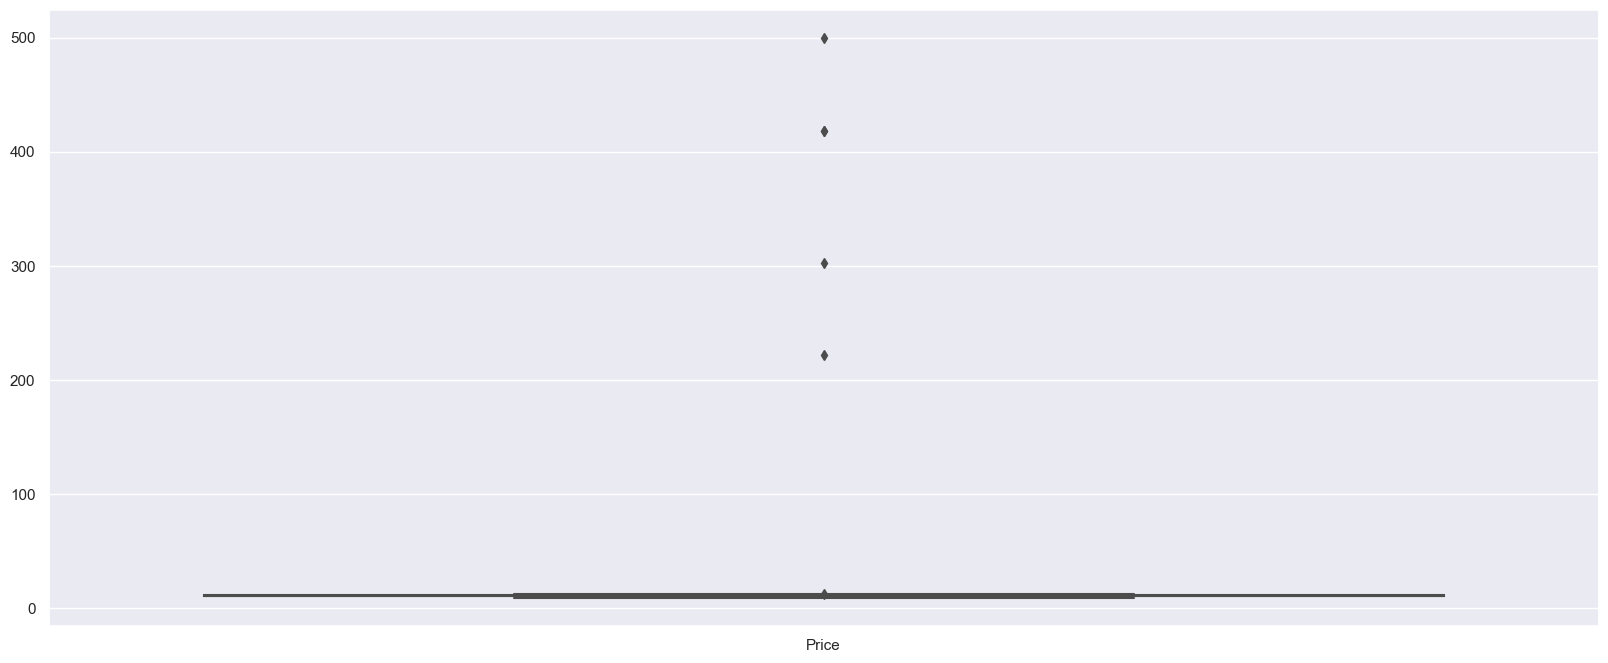

In [17]:
# Analizar valores atipicos en la variable de interes

df_compu_prep_var = df_compu_prep[['Price']].copy()
fig=plt.figure(figsize=(20,8))-
ax = sns.boxplot(data=df_compu_prep_var, orient ="v")

In [19]:
#Eliminar los outliers price
Q1 = df_compu_prep['Price'].quantile(0.25)
Q3 = df_compu_prep['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_compu_prep = df_compu_prep[(df_compu_prep['Price'] >= lower_bound) & (df_compu_prep['Price'] <= upper_bound)]

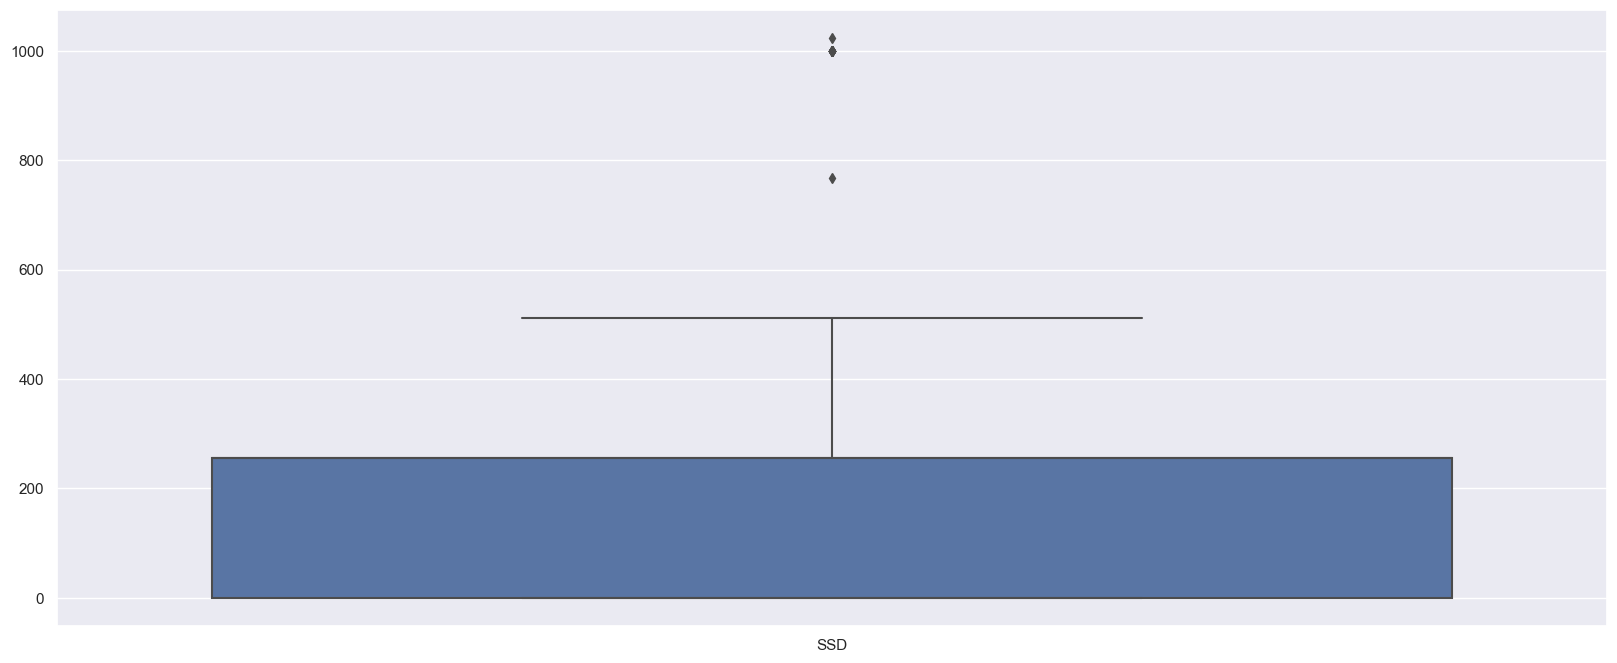

In [46]:
# Analizar valores atipicos en la variable SSD

df_compu_prep_var = df_compu_prep[['SSD']].copy()
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_compu_prep_var, orient ="v")

In [47]:
#Eliminar los outliers price
Q1 = df_compu_prep['SSD'].quantile(0.25)
Q3 = df_compu_prep['SSD'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_compu_prep = df_compu_prep[(df_compu_prep['SSD'] >= lower_bound) & (df_compu_prep['SSD'] <= upper_bound)]

In [20]:
#Sacamos las variables numericas y categoricas
features_num = ["Ram", "Weight", "Ppi", "HDD", "SSD"]
features_cat = ["Company", "TypeName", "TouchScreen", "Ips", "Cpu_brand", "Gpu_brand", "Os"]

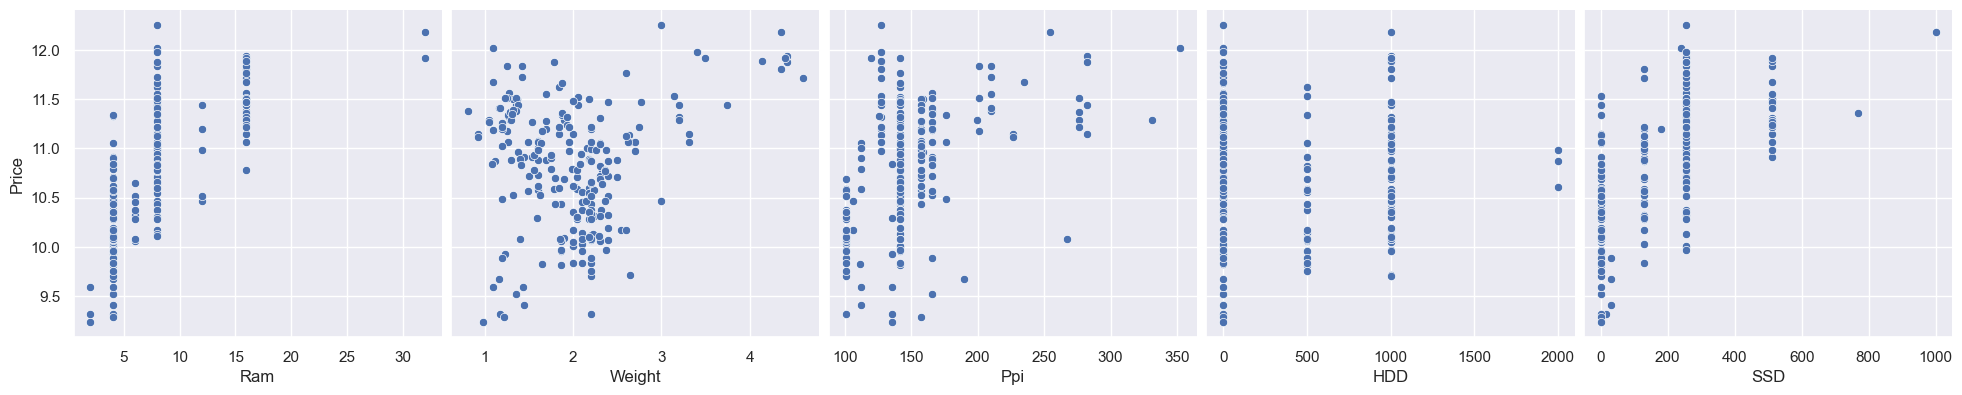

In [21]:
#Relación de la variable objetivo con las demas variables
sns.pairplot(df_compu_prep.sample(frac=0.2), height=4, y_vars="Price", x_vars=features_num, kind="scatter")

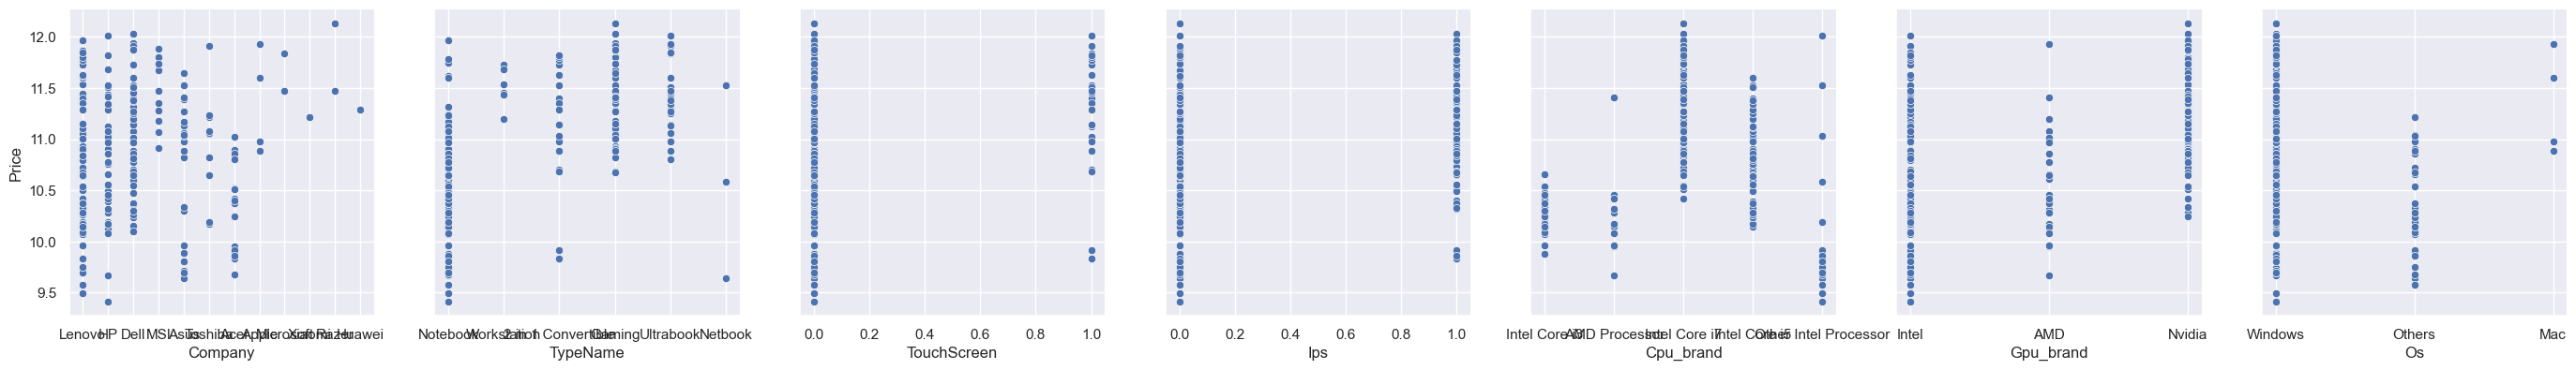

In [22]:
#Relación de la variable objetivo con las demas variables
sns.pairplot(df_compu_prep.sample(frac=0.2), height=4, y_vars="Price", x_vars=features_cat, kind="scatter")

<AxesSubplot:>

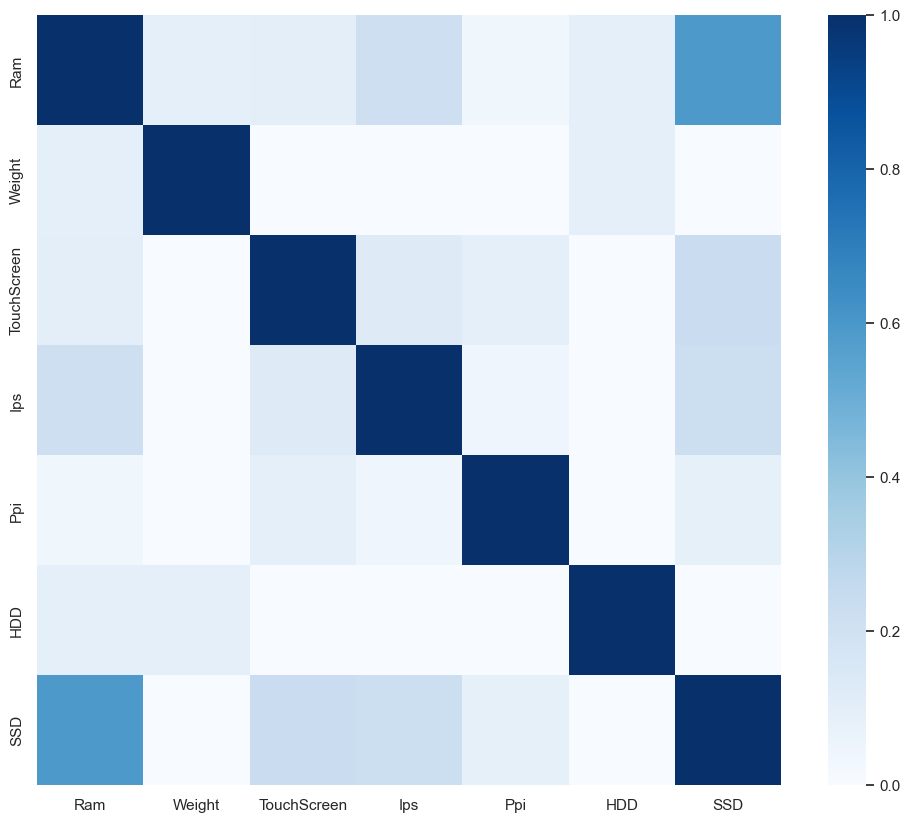

In [23]:
# Correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(df_compu_prep[features].corr(), cmap="Blues", vmin=0, vmax=1)

In [24]:
#Pasar la variable procesador a numerica utilizando label encoder
label_encoder = LabelEncoder()
custom_order = {'Other Intel Processor': 0, 'AMD Processor': 1, 'Intel Core i3': 2, 'Intel Core i5': 3, 'Intel Core i7': 4}


#df_compu_prep['Cpu_brand'] = pd.Categorical(df_compu_prep['Cpu_brand'], categories=custom_order, ordered=True)
df_compu_prep['Cpu_brand_encoded'] = df_compu_prep['Cpu_brand'].map(custom_order)
df_compu_prep.Cpu_brand.value_counts()

Intel Core i7            478
Intel Core i5            379
Intel Core i3            124
Other Intel Processor    123
AMD Processor             56
Name: Cpu_brand, dtype: int64

In [25]:
df_compu_prep.Ram.value_counts()

8     558
4     329
16    185
6      33
12     24
32     15
2      13
24      2
64      1
Name: Ram, dtype: int64

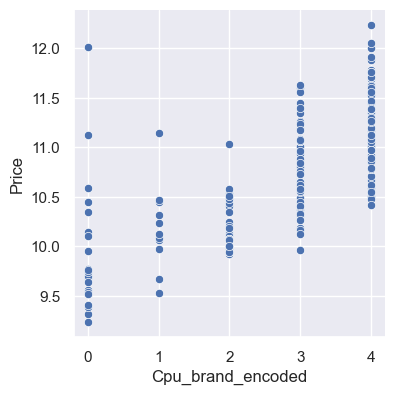

In [26]:
sns.pairplot(df_compu_prep.sample(frac=0.2), height=4, y_vars="Price", x_vars="Cpu_brand_encoded", kind="scatter")

In [27]:
#Pasar la variable Ram a categorica
custom_order = {2: 0, 4: 1, 6: 2, 8: 3, 12: 4, 16: 5, 24: 6, 32: 7, 64: 8}


#df_compu_prep['Cpu_brand'] = pd.Categorical(df_compu_prep['Cpu_brand'], categories=custom_order, ordered=True)
df_compu_prep['Ram_encoded'] = df_compu_prep['Ram'].map(custom_order)
df_compu_prep.Ram.value_counts()

8     558
4     329
16    185
6      33
12     24
32     15
2      13
24      2
64      1
Name: Ram, dtype: int64

In [28]:
df_compu_prep.Ram_encoded.value_counts()

3    558
1    329
5    185
2     33
4     24
7     15
0     13
6      2
8      1
Name: Ram_encoded, dtype: int64

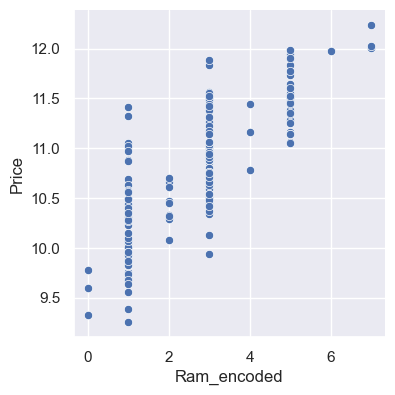

In [29]:
sns.pairplot(df_compu_prep.sample(frac=0.2), height=4, y_vars="Price", x_vars="Ram_encoded", kind="scatter")

## 7. Entrenamiento del modelo

### 7.1 Selección de variables

In [49]:
#Se copian las variables a utilizar

var_selec = ["Ram_encoded", "SSD", "Cpu_brand_encoded"]

df_compu_model_X = df_compu_prep[var_selec].copy()
df_compu_model_Y = df_compu_prep["Price"].copy()

In [54]:
# Vamos a llevar al mismo dominio las diferentes variables
mms= MinMaxScaler()
# transform data
df_compu_Xnorm = mms.fit_transform(df_compu_model_X[var_selec])
df_compu_model_X = pd.DataFrame(df_compu_Xnorm, columns =var_selec)

In [59]:
df_compu_model_X.head()

Ram_encoded  SSD  Cpu_brand_encoded
0     0.142857  0.0               0.50
1     0.428571  0.0               0.75
2     0.428571  0.5               0.75
3     0.571429  1.0               1.00
4     0.428571  0.5               1.00

### 7.2 Entrenamiento del modelo

In [55]:
# Se entrena el modelo con los datos de entrenamiento elegidos
regression = LinearRegression()
regression.fit(df_compu_model_X, df_compu_model_Y)

LinearRegression()

In [56]:
pd.DataFrame({"columns": var_selec, "coef": regression.coef_})

columns      coef
0        Ram_encoded  1.139603
1                SSD  0.507490
2  Cpu_brand_encoded  0.683438

In [57]:
regression.intercept_

9.709205538931714

## 8. Validación del modelo

In [ ]:
# Calculo del error MAE
print("Train:", mean_absolute_error(df_compu_model_Y, regression.predict(df_compu_model_X)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))